In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F
import torch.nn.init as init

# 데이터 로드 함수
def load_raisin_data(file_path):
    """Raisin 데이터셋을 로드하는 함수"""
    df = pd.read_excel(file_path, sheet_name='Raisin_Grains_Dataset')
    return df

# 데이터 전처리 함수
def preprocess_data(df):
    """데이터 전처리를 수행하는 함수"""
    # 결측값 확인
    print("Missing values check:")
    print(df.isnull().sum())
    print("\n")
    
    # 특성과 타겟 분리
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # 레이블 인코딩
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    return X, y, y_encoded, le

# 데이터 탐색 함수
def explore_data(df):
    """데이터 탐색을 수행하는 함수"""
    print("=== Dataset Basic Information ===")
    print(f"Data shape: {df.shape}")
    print(f"Class distribution:")
    print(df['Class'].value_counts())
    print("\n")
    
    print("=== Basic Statistics ===")
    print(df.describe())
    print("\n")
    
    # 클래스별 특성 통계
    print("=== Class-wise Mean Values ===")
    class_stats = df.groupby('Class').mean()
    print(class_stats)
    print("\n")
    
    return class_stats


In [2]:

# PyTorch 모델 정의
class MLPClassifier(nn.Module):
    """다층 퍼셉트론 분류기"""
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], num_classes=2, dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class CNNClassifier(nn.Module):
    """1D CNN 분류기 (시계열 데이터처럼 처리)"""
    def __init__(self, input_size, num_classes=2, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

class LSTMClassifier(nn.Module):
    """LSTM 분류기"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=2, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # 마지막 출력만 사용
        output = lstm_out[:, -1, :]
        output = self.dropout(output)
        output = self.fc(output)
        
        return output

# PyTorch 데이터셋 클래스
class RaisinDataset(Dataset):
    """Raisin 데이터셋을 위한 PyTorch Dataset"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 시각화 함수
def create_visualizations(df):
    """데이터 시각화를 생성하는 함수"""
    plt.figure(figsize=(15, 12))
    
    # 1. 클래스 분포
    plt.subplot(2, 3, 1)
    df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # 2. 상관관계 히트맵
    plt.subplot(2, 3, 2)
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix')
    
    # 3-6. 주요 특성들의 분포 (클래스별)
    features_to_plot = ['Area', 'MajorAxisLength', 'Eccentricity', 'Perimeter']
    for i, feature in enumerate(features_to_plot, 3):
        plt.subplot(2, 3, i)
        for class_name in df['Class'].unique():
            class_data = df[df['Class'] == class_name][feature]
            plt.hist(class_data, alpha=0.6, label=class_name, bins=30)
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# PyTorch 모델들을 정의하는 함수
def get_pytorch_models(input_size, num_classes=2):
    """다양한 PyTorch 모델들을 반환하는 함수"""
    models = {
        'MLP': MLPClassifier(input_size, [128, 64, 32], num_classes),
        'CNN': CNNClassifier(input_size, num_classes),
        'LSTM': LSTMClassifier(input_size, 64, 2, num_classes),
    }
    return models

# PyTorch 훈련 함수
def train_pytorch_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    """PyTorch 모델을 훈련하는 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        # 평균 계산
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # 학습률 스케줄링
        scheduler.step(avg_val_loss)
        
        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # 진행 상황 출력 (10 에포크마다)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

# PyTorch 모델 평가 함수
def evaluate_pytorch_model(model, test_loader, le, device='cpu'):
    """PyTorch 모델을 평가하는 함수"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    # 정확도 계산
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # 분류 리포트
    target_names = le.classes_
    report = classification_report(all_labels, all_predictions, target_names=target_names, output_dict=True)
    
    # 혼동 행렬
    cm = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_labels

# PyTorch 모델들을 학습하고 평가하는 함수
def train_and_evaluate_pytorch_models(X_train, X_val, X_test, y_train, y_val, y_test, models, le, device='cpu'):
    """PyTorch 모델들을 학습하고 평가하는 함수"""
    results = {}
    training_histories = {}
    
    print("=== PyTorch Model Performance Evaluation ===")
    print("-" * 80)
    
    # 데이터로더 생성
    train_dataset = RaisinDataset(X_train, y_train)
    val_dataset = RaisinDataset(X_val, y_val)
    test_dataset = RaisinDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    for name, model in models.items():
        print(f"\n{name} model training...")
        
        # 모델 훈련
        training_result = train_pytorch_model(model, train_loader, val_loader, device=device)
        training_histories[name] = training_result
        
        # 모델 평가
        accuracy, report, cm, predictions, labels = evaluate_pytorch_model(
            training_result['model'], test_loader, le, device
        )
        
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm,
            'predictions': predictions,
            'labels': labels
        }
        
        print(f"\n{name} model results:")
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Best validation accuracy: {training_result['best_val_acc']:.2f}%")
        
        # 상세 분류 리포트
        print("Classification report:")
        target_names = le.classes_
        print(classification_report(labels, predictions, target_names=target_names))
        
        # 혼동 행렬
        print("Confusion matrix:")
        print(cm)
        print("-" * 80)
    
    return results, training_histories

# PyTorch 교차 검증 함수
def perform_pytorch_cross_validation(X, y, models, k_folds=5, device='cpu'):
    """PyTorch 모델들에 대해 교차 검증을 수행하는 함수"""
    
    print(f"=== {k_folds}-Fold Cross Validation Results (PyTorch) ===")
    print("-" * 60)
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_results = {}
    
    for name, model_class in models.items():
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            # 데이터 분할
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # 데이터로더 생성
            train_dataset = RaisinDataset(X_train_fold, y_train_fold)
            val_dataset = RaisinDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
            
            # 모델 인스턴스 생성
            model = model_class
            
            # 모델 훈련 (빠른 훈련을 위해 에포크 수 줄임)
            training_result = train_pytorch_model(model, train_loader, val_loader, 
                                                num_epochs=50, device=device)
            
            # 검증 정확도 저장
            fold_scores.append(training_result['best_val_acc'] / 100)  # 백분율을 소수로 변환
        
        cv_results[name] = {
            'mean': np.mean(fold_scores),
            'std': np.std(fold_scores),
            'scores': fold_scores
        }
        
        print(f"{name}:")
        print(f"  Mean accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores) * 2:.4f})")
        print(f"  Score range: {np.min(fold_scores):.4f} ~ {np.max(fold_scores):.4f}")
        print()
    
    return cv_results

# 훈련 히스토리 시각화 함수
def plot_training_history(training_histories):
    """훈련 히스토리를 시각화하는 함수"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for i, (name, history) in enumerate(training_histories.items()):
        # Loss 그래프
        axes[0, 0].plot(history['train_losses'], label=f'{name} Train', alpha=0.7)
        axes[0, 0].plot(history['val_losses'], label=f'{name} Val', alpha=0.7)
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Accuracy 그래프
        axes[0, 1].plot(history['train_accuracies'], label=f'{name} Train', alpha=0.7)
        axes[0, 1].plot(history['val_accuracies'], label=f'{name} Val', alpha=0.7)
        axes[0, 1].set_title('Training Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # 최종 성능 비교
    model_names = list(training_histories.keys())
    final_train_accs = [history['train_accuracies'][-1] for history in training_histories.values()]
    final_val_accs = [history['val_accuracies'][-1] for history in training_histories.values()]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, final_train_accs, width, label='Train', alpha=0.7)
    axes[1, 0].bar(x + width/2, final_val_accs, width, label='Validation', alpha=0.7)
    axes[1, 0].set_title('Final Accuracy Comparison')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(model_names, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 최고 검증 정확도 비교
    best_val_accs = [history['best_val_acc'] for history in training_histories.values()]
    axes[1, 1].bar(model_names, best_val_accs, alpha=0.7, color='skyblue')
    axes[1, 1].set_title('Best Validation Accuracy')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('Best Accuracy (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 값 표시
    for i, v in enumerate(best_val_accs):
        axes[1, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Using device: cuda
=== Dataset Basic Information ===
Data shape: (900, 8)
Class distribution:
Class
Kecimen    450
Besni      450
Name: count, dtype: int64


=== Basic Statistics ===
                Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
count     900.000000       900.000000       900.000000    900.000000   
mean    87804.127778       430.929950       254.488133      0.781542   
std     39002.111390       116.035121        49.988902      0.090318   
min     25387.000000       225.629541       143.710872      0.348730   
25%     59348.000000       345.442898       219.111126      0.741766   
50%     78902.000000       407.803951       247.848409      0.798846   
75%    105028.250000       494.187014       279.888575      0.842571   
max    235047.000000       997.291941       492.275279      0.962124   

          ConvexArea      Extent    Perimeter  
count     900.000000  900.000000   900.000000  
mean    91186.090000    0.699508  1165.906636  
std     40769.290132    

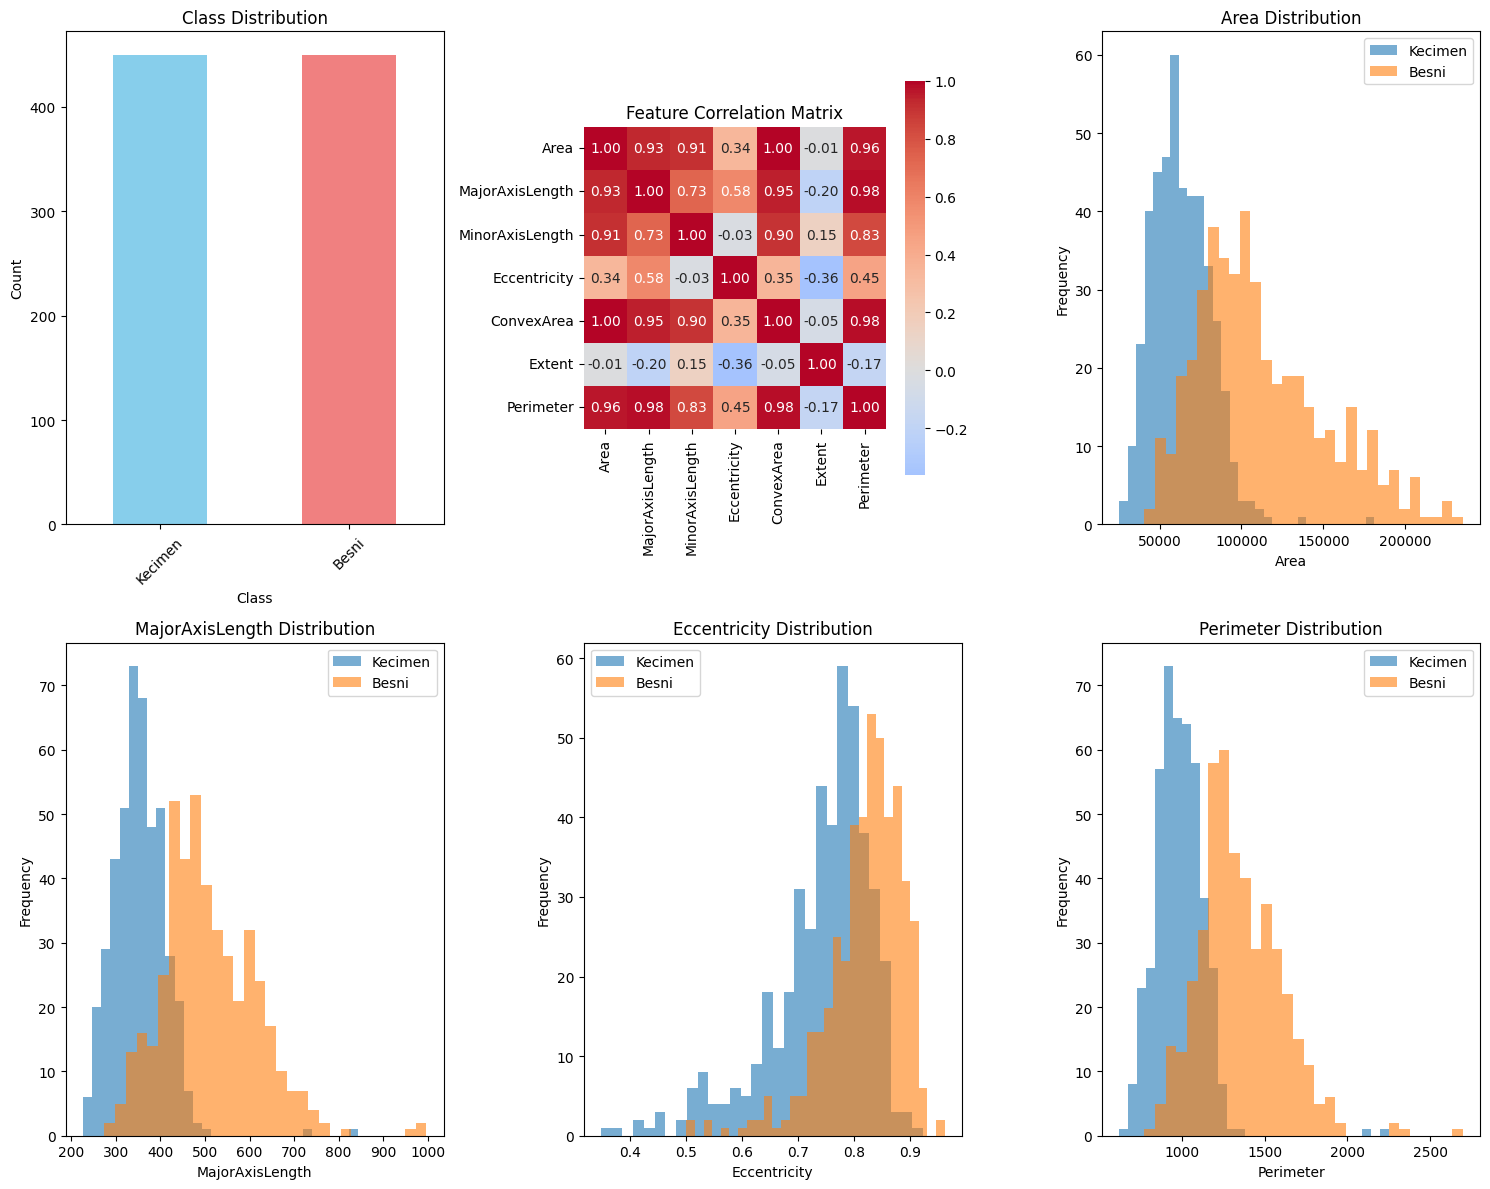

Missing values check:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64


Training set size: (540, 7)
Validation set size: (180, 7)
Test set size: (180, 7)

=== PyTorch Model Performance Evaluation ===
--------------------------------------------------------------------------------

MLP model training...
Epoch [10/100], Train Loss: 0.4073, Train Acc: 85.00%, Val Loss: 0.3351, Val Acc: 86.67%
Epoch [20/100], Train Loss: 0.3551, Train Acc: 85.19%, Val Loss: 0.3311, Val Acc: 87.22%
Epoch [30/100], Train Loss: 0.3321, Train Acc: 86.85%, Val Loss: 0.3244, Val Acc: 87.22%
Epoch [40/100], Train Loss: 0.3423, Train Acc: 86.11%, Val Loss: 0.3162, Val Acc: 87.22%
Epoch [50/100], Train Loss: 0.3550, Train Acc: 85.74%, Val Loss: 0.3126, Val Acc: 86.67%
Epoch [60/100], Train Loss: 0.3453, Train Acc: 85.56%, Val Loss: 0.3026, Val Acc: 86.67%
Epoch [70/100], Train Loss: 0

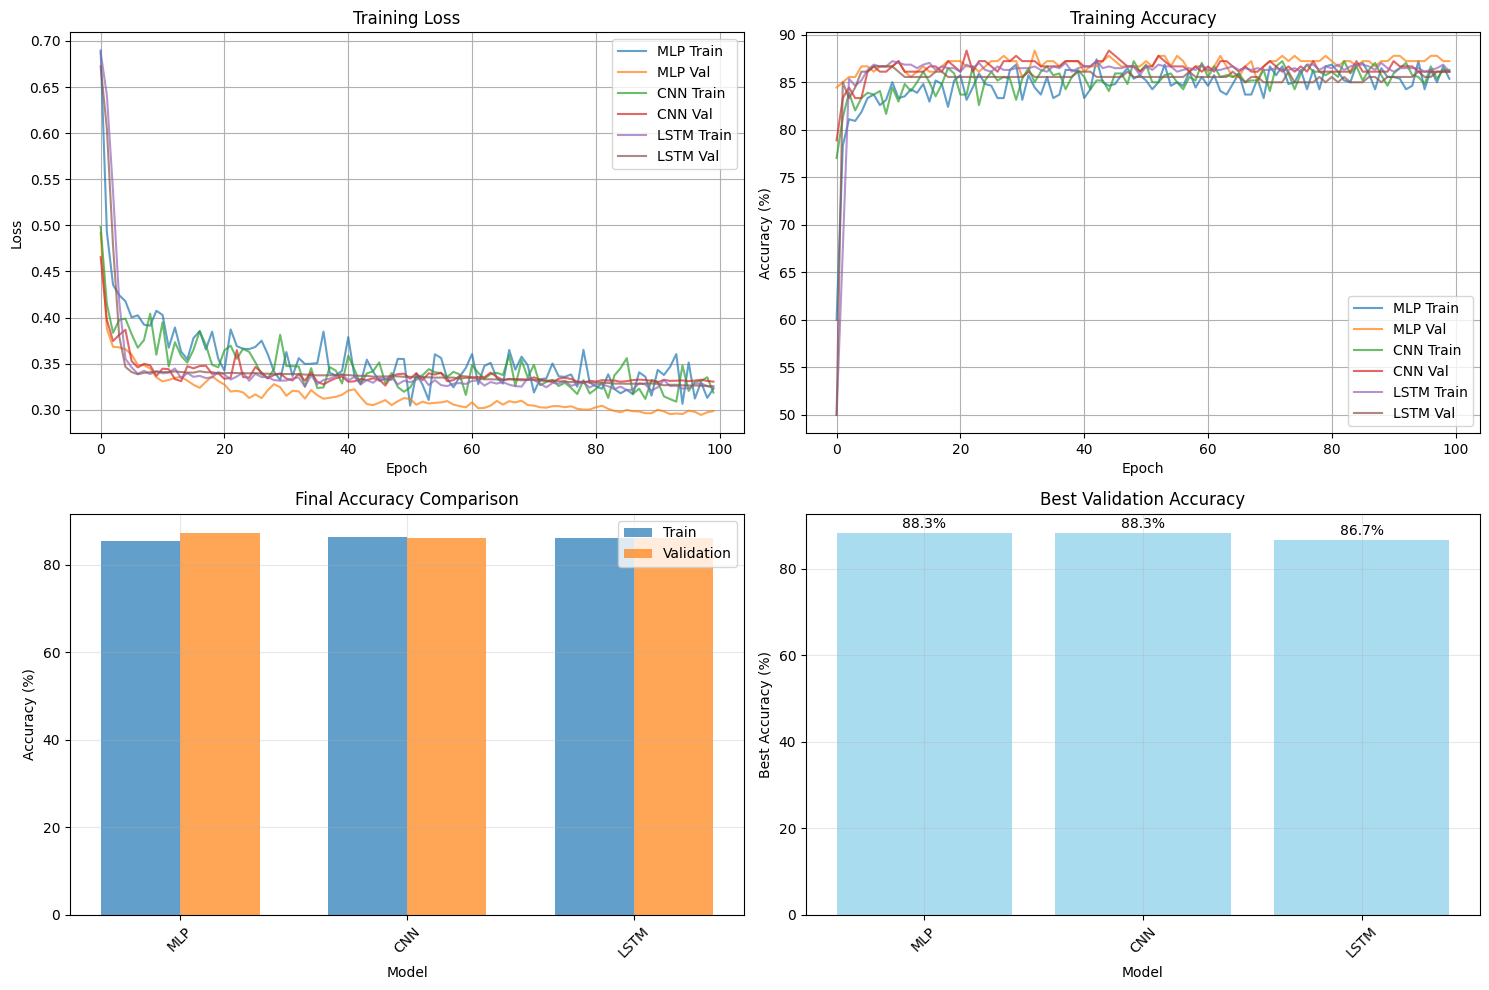

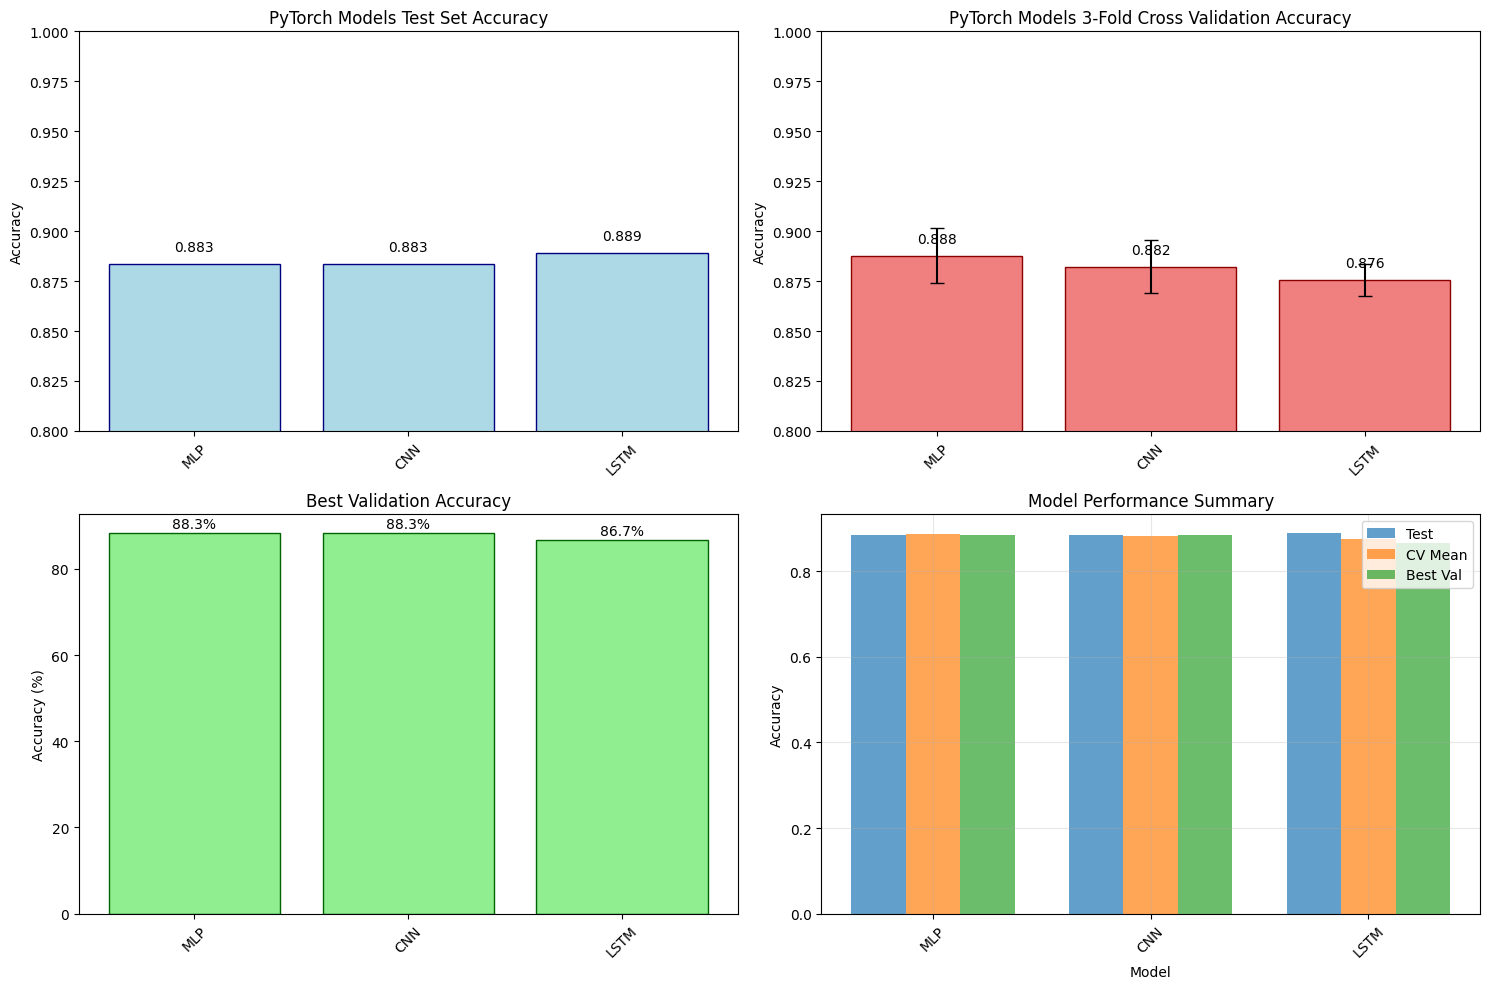


=== Best Performing PyTorch Model ===
Model: LSTM
Test accuracy: 0.8889
Cross validation mean accuracy: 0.8756
Best validation accuracy: 86.67%


In [3]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드 (파일 경로를 실제 경로로 변경하세요)
file_path = 'dataset/Raisin_Dataset/Raisin_Dataset.xlsx'
df = load_raisin_data(file_path)

# 데이터 탐색
class_stats = explore_data(df)

# 시각화 생성
create_visualizations(df)

# 데이터 전처리
X, y, y_encoded, le = preprocess_data(df)

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할 (훈련/검증/테스트)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")
print()

# PyTorch 모델 정의
input_size = X_train.shape[1]
num_classes = len(le.classes_)
models = get_pytorch_models(input_size, num_classes)

# 모델 학습 및 평가
results, training_histories = train_and_evaluate_pytorch_models(
    X_train, X_val, X_test, y_train, y_val, y_test, models, le, device
)

# 교차 검증 (빠른 실행을 위해 3-fold로 설정)
print("\nPerforming cross validation...")
cv_results = perform_pytorch_cross_validation(X_scaled, y_encoded, models, k_folds=3, device=device)

# 훈련 히스토리 시각화
plot_training_history(training_histories)

# 결과 시각화
plt.figure(figsize=(15, 10))

# 테스트 세트 정확도
plt.subplot(2, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
bars = plt.bar(model_names, accuracies, color='lightblue', edgecolor='navy')
plt.title('PyTorch Models Test Set Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

# 정확도 값 표시
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{acc:.3f}', ha='center', va='bottom')

# 교차 검증 정확도
plt.subplot(2, 2, 2)
cv_means = [cv_results[name]['mean'] for name in model_names]
cv_stds = [cv_results[name]['std'] for name in model_names]
bars = plt.bar(model_names, cv_means, yerr=cv_stds, color='lightcoral', edgecolor='darkred', capsize=5)
plt.title('PyTorch Models 3-Fold Cross Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

# 정확도 값 표시
for bar, mean in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{mean:.3f}', ha='center', va='bottom')

# 최고 검증 정확도 비교
plt.subplot(2, 2, 3)
best_val_accs = [training_histories[name]['best_val_acc'] for name in model_names]
bars = plt.bar(model_names, best_val_accs, color='lightgreen', edgecolor='darkgreen')
plt.title('Best Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

# 정확도 값 표시
for bar, acc in zip(bars, best_val_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{acc:.1f}%', ha='center', va='bottom')

# 모델별 성능 요약
plt.subplot(2, 2, 4)
x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, accuracies, width, label='Test', alpha=0.7)
plt.bar(x, cv_means, width, label='CV Mean', alpha=0.7)
plt.bar(x + width, [acc/100 for acc in best_val_accs], width, label='Best Val', alpha=0.7)

plt.title('Model Performance Summary')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최고 성능 모델 찾기
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"\n=== Best Performing PyTorch Model ===")
print(f"Model: {best_model_name}")
print(f"Test accuracy: {best_accuracy:.4f}")
print(f"Cross validation mean accuracy: {cv_results[best_model_name]['mean']:.4f}")
print(f"Best validation accuracy: {training_histories[best_model_name]['best_val_acc']:.2f}%")
